### 🎯 FlightVision
* Testing inference speed

In [ ]:
!pip install opencv-python tqdm imutils -q

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.1MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 194kB 15.5MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.1MB 19.7MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 40kB 5.7MB/s 
     |████████████████████████████████| 5.9MB 8.6MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 748.8MB 23kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 2.6MB 62.1MB/s 
Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import imutils

import fastai
#from fastai.vision.all import *
#from fastai.vision.all import *
from fastai.basics import *
#from fastai.callback.all import *
from matplotlib import pyplot as plt
import cv2
import pathlib

print(f' Fastai {fastai2.__version__}\nPytorch {torch.__version__}\n OpenCV {cv2.__version__}')
try:
  print(f'    GPU {torch.cuda.get_device_name(0)}')
  torch.cuda.device(0)
except: print("No GPU detected")

 Fastai 0.0.30
Pytorch 1.6.0+cu101
 OpenCV 4.1.2
    GPU Tesla V100-SXM2-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Test Inference Speed


In [ ]:
# Get test data from drive
!mkdir images
!cp -v "drive/My Drive/FlightVision/data/combine950/Snapshot_20200310_10.JPG" "./images"

mkdir: cannot create directory ‘images’: File exists
'drive/My Drive/FlightVision/data/combine950/Snapshot_20200310_10.JPG' -> './images/Snapshot_20200310_10.JPG'


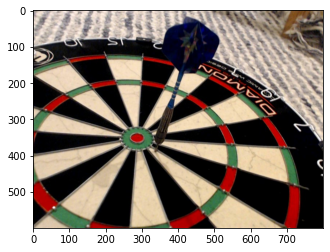

In [ ]:
# Open sample image
image = cv2.imread('images/Snapshot_20200310_10.JPG', cv2.IMREAD_COLOR)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_im)
plt.show()

In [ ]:
imgs = (Path("images/")).ls()
imgs

[Path('images/Snapshot_20200310_10.JPG')]

In [ ]:
from fastai.vision.all import *

In [ ]:
# test from here

learn = cnn_learner(dls, resnet34)

In [ ]:
#%%time
# Define learner `get functions` and import weights 

def get_x(f):
    return f"data/combine950/{f['External ID']}"

def get_mask(f):
    return f"data/{f['External ID']}"

def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

learn = load_learner('drive/My Drive/FlightVision/models/fv_nb016')


In [ ]:
learn = load_learner('drive/My Drive/FlightVision/models/fv_nb016', 'export.pkl')

In [ ]:
%%time
img_path = 'images/Snapshot_20200310_10.JPG'

out = learn.predict(img_path)

CPU times: user 16.8 s, sys: 2.67 s, total: 19.5 s
Wall time: 10.2 s


Centroid located: (337, 391)


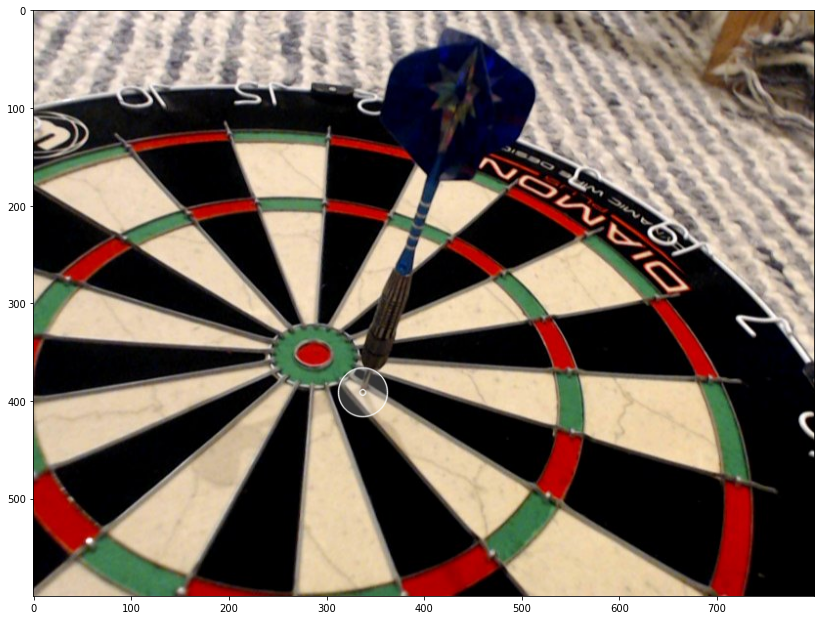

CPU times: user 556 ms, sys: 2.05 ms, total: 558 ms
Wall time: 552 ms


In [ ]:
%%time

img = image[:, :, ::-1].copy() 
img_out = out[0].numpy()
img_out = cv2.convertScaleAbs(img_out)

# Find contours in the binary image
contours = cv2.findContours(img_out, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

for c in contours:
    # Calculate moments for each contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    print("Centroid located:", (cX, cY))
    
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Transparency layer
    overlay = img.copy()
    output = img.copy()
    inner_colour = (255, 255, 255)
    outer_colour = (255, 255, 255)
    cv2.circle(overlay, (cX, cY), 25, outer_colour, -1)
    alpha = 0.2
    cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)

    # Dart point
    cv2.circle(output, (cX, cY), 25, outer_colour, 1, cv2.LINE_AA)
    cv2.circle(output, (cX, cY), 3, inner_colour, 1, cv2.LINE_AA)
    #cv2.putText(output, f"{(cX, cY)}", (cX - 105, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 
    #            0.5, inner_colour, 1, cv2.LINE_AA)

plt.figure(figsize = (14, 14))
plt.imshow(output)
plt.show()